Ici, nous prédisons la consommation énergétique totale des propriétés.

# 1 - Importation des librairies et du fichier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import random

from sklearn.dummy import DummyRegressor
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

from category_encoders import TargetEncoder

from xgboost import XGBRegressor

import shap
shap.initjs()

import time

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

C:\Users\cheno\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
file = "file_cleaned.csv"
data = pd.read_csv(file)

In [3]:
# On fixe le seed des random_state
seed = 42

In [4]:
def log10_transform(x):
    '''
    Retourne le logarithme en base 10 de x
    Args:
        x (float) : Nombre réel strictement positif
    '''
    return np.log10(x)

Les modèles que nous allons entrainer vont prédire le logarithme en base 10 de y. Les métriques classiques retourneront donc l'erreur sur le logarithme alors que nous souhaitons avoir l'erreur sur la valeur réelle. Nous allons donc créer une métrique personnalisée afin de corriger celà.

In [5]:
def custom_metric(y, y_pred):
    '''
    Retourne 100 * sum(|10^y - 10^y_pred|) / sum(10^y)
    Args:
        y (ndarray shape (n,)) : log10 des valeurs réelles
        y_pred (ndarray shape (n,)) : log10 des valeurs prédites
    '''
    return 100 * np.sum(np.abs(10**y - 10**y_pred)) / np.sum(10**y)

In [6]:
custom_error = make_scorer(custom_metric, greater_is_better=False)

Ecrivons une fonction qui va retourner les résultats de GridSearchCV sous forme de DataFrame.

In [7]:
def resultize(grid, rank_by):
    '''
    Retourne les résultats de GridSearchCV sous forme de dataframe
    Args:
        grid : une instanciation de sklearn.model_selection.GridSearchCV
        rank_by : la colonne selon laquelle trier les résultats
    Returns:
        res (DataFrame) : le dataframe des résultats de grid
    '''
    res = pd.DataFrame(grid.cv_results_)
    cols = [col for col in res.columns if "split" not in col]
    res = res[cols]
    res = res.sort_values(rank_by).reset_index(drop=True)
    
    return res

Ecrivons une fonction qui va enregistrer dans un dictionnaire les paramètres et les métriques du meilleur résultat de cross validation de chacun des modèles que nous allons essayer.

In [8]:
cols=["mean_test_custom_error", "std_test_custom_error",
      "mean_train_custom_error", "std_train_custom_error",
      "mean_fit_time", "std_fit_time", "params",]

best_models_results = {
                       "model_name": [], 
                       "mean_test_custom_error": [],
                       "std_test_custom_error": [],
                       "mean_train_custom_error": [],
                       "std_train_custom_error": [],
                       "mean_fit_time": [],
                       "std_fit_time": [],
                       "parameters": [],
                      }

In [9]:
def append_results(dict_, grid, model_name, columns, idx=0):
    '''
    Ajoute les résultats de GridSearchCV dans dict_
    Args:
        dict_ (dict of lists, len=n)
        grid : une instanciation de sklearn.model_selection.GridSearchCV
        model_name (string) : the name of the model we append
        columns (list of strings, len=n-1) : les colonnes à extraire de grid
        idx (int) : l'indice du modèle retenu
    '''
    # On enregistre les clés de dict_ dans une liste
    keys_ = list(dict_)
    
    dict_[keys_[0]].append(model_name)
    for key_, col in list(zip(keys_[1:], columns)):
        dict_[key_].append(resultize(grid, "rank_test_custom_error")\
                           .loc[[idx], col].values[0])

# 2 - GridSearchCV avec OneHotEncoding

#### Selection des features et du target

In [10]:
categorical_features = ["CouncilDistrictCode", "YearBuilt_20"]
numerical_features = ["NumberofFloors", "NumberOfPropertyUseTypes", 
                      "PropertyGFATotal"]
ratio_features = ["OfficeRatio", "OtherRatio", "ParkingRatio", 
                  "RecreationRatio", "ResidenceRatio", "RestaurantRatio", 
                  "SchoolRatio", "StoreRatio", "WarehouseRatio",
                  "ElectricityRatio", "SteamUseRatio",]
X = data.copy().loc[:, [*categorical_features, *numerical_features, 
                        *ratio_features]]
y = data.copy().loc[:, "SiteEnergyUse"]

# Comme évoqué dans le notebook d'exploration, nous allons appliquer une
# transformation logarithmique au target.
y = np.log10(y)

#### Séparation des données

In [11]:
# La stratification sert à s'assurer que le split sélectionne des individus
# statistiques de consommations énergétiques variées (du moins énergivore 
# au plus énergivore)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=seed, 
                     stratify=data["SiteEUI_bins"])

#### Transformation des colonnes

In [12]:
r_scaler = RobustScaler()
log_transformer = FunctionTransformer(log10_transform)
oh_enc = OneHotEncoder(drop="first")

ct_1 = ColumnTransformer(
     transformers=[("log_transformer", log_transformer, ["PropertyGFATotal"]), 
                   ("one_hot_encoder", oh_enc, categorical_features), 
                   ("scaler", r_scaler, ["NumberofFloors"])
                  ], 
    remainder="passthrough",
    n_jobs=-1)

#### Résulats avec une regression naïve

In [13]:
dum = DummyRegressor(strategy="mean")

# Entrainement
pipe_dum = Pipeline(steps=[("preprocessing", ct_1), ("dummy", dum)])
pipe_dum.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred_dum = pipe_dum.predict(X_test)

# Evaluate
print(f"custom error : {custom_metric(y_test, y_pred_dum):.1f}")

custom error : 76.2


## 2.1 - Ridge

In [14]:
ridge = Ridge(random_state=seed)

# Grille de paramètres
param_grid = {"alpha": [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                        0.3, 0.6, 1, 3, 6, 10]}

# critère de sélection du meilleur modèle
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_ridge = GridSearchCV(
                          estimator=ridge, 
                          param_grid=param_grid, 
                          cv=5, 
                          scoring=score,
                          refit="custom_error",
                          return_train_score=True,
                          verbose=2,
                          n_jobs=-1,
                         )

# On automatise le preprocessing et l'entrainement 
pipe_ridge = Pipeline(steps=[("preprocessing", ct_1), 
                             ("grid_ridge", grid_ridge)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x000001D217BE2430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('grid_ridge',
                 GridSearchCV(cv=5, estimator=Ridge(random_state=42), n_jobs=-1,
                              param_grid={'alpha': [0.001, 0.003, 0.006, 0

In [15]:
# Résultat de GridSearch
resultize(pipe_ridge.named_steps["grid_ridge"], 
          "rank_test_custom_error").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.001796,0.000398,0.000802,0.000401,6,{'alpha': 6},-42.542608,1.797430,1,-41.771038,0.484140
1,0.001200,0.000403,0.001003,0.000007,3,{'alpha': 3},-42.603598,1.979284,2,-41.817012,0.483304
2,0.001399,0.000492,0.000801,0.000401,10,{'alpha': 10},-42.781922,1.792414,3,-42.015103,0.491823
3,0.001799,0.000399,0.000799,0.000400,1,{'alpha': 1},-42.875419,2.183257,4,-42.006362,0.446953
4,0.001607,0.000800,0.001395,0.000484,0.6,{'alpha': 0.6},-42.954371,2.242011,5,-42.049647,0.441684
5,0.001805,0.000402,0.001396,0.000495,0.3,{'alpha': 0.3},-43.011897,2.287365,6,-42.080970,0.442047
6,0.001796,0.000396,0.001199,0.000401,0.1,{'alpha': 0.1},-43.047084,2.324107,7,-42.102717,0.445185
7,0.001401,0.000491,0.001604,0.000496,0.06,{'alpha': 0.06},-43.053867,2.332898,8,-42.106667,0.446295
8,0.001805,0.000403,0.001199,0.000401,0.03,{'alpha': 0.03},-43.058653,2.339647,9,-42.109589,0.447145
9,0.001801,0.000401,0.000997,0.000002,0.01,{'alpha': 0.01},-43.061687,2.344232,10,-42.111582,0.447678


In [16]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               pipe_ridge.named_steps["grid_ridge"],  
               "ridge_ohe", 
               cols)

## 2.2 - Linear SVR

In [17]:
linear_svr = LinearSVR(random_state=seed, tol=0.1)

# Grille de paramètres
param_grid = {
              "C": np.logspace(-2, 3, 6),
              "epsilon": [0, 0.1, 1],
              "max_iter": [1e3, 5e3, 1e4]
             }

# critère de sélection du meilleur modèle
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_linear_svr = GridSearchCV(
                              estimator=linear_svr, 
                              param_grid=param_grid, 
                              cv=5, 
                              scoring=score,
                              refit="custom_error",
                              return_train_score=True,
                              verbose=2,
                              n_jobs=-1,
                             )

# On automatise le preprocessing et l'entrainement 
pipe_linear_svr = Pipeline(steps=[("preprocessing", ct_1), 
                                  ("grid_linear_svr", grid_linear_svr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_linear_svr.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x000001D217BE2430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('grid_linear_svr',
                 GridSearchCV(cv=5,
                              estimator=LinearSVR(random_state=42, tol=0.1),
                              n_jobs=

In [18]:
# Résultat de GridSearch
resultize(pipe_linear_svr.named_steps["grid_linear_svr"], 
          "rank_test_custom_error").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_max_iter,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.128874,0.004184,0.001200,4.001625e-04,10.0,0,5000.0,"{'C': 10.0, 'epsilon': 0, 'max_iter': 5000.0}",-42.923505,2.152581,1,-43.133186,0.889348
1,0.126393,0.002974,0.001414,4.797244e-04,10.0,0,10000.0,"{'C': 10.0, 'epsilon': 0, 'max_iter': 10000.0}",-42.923505,2.152581,1,-43.133186,0.889348
2,0.017701,0.001011,0.001200,3.992082e-04,1.0,0.1,10000.0,"{'C': 1.0, 'epsilon': 0.1, 'max_iter': 10000.0}",-43.093636,1.403383,3,-42.504599,0.945295
3,0.020399,0.002871,0.001400,4.910899e-04,1.0,0.1,5000.0,"{'C': 1.0, 'epsilon': 0.1, 'max_iter': 5000.0}",-43.093636,1.403383,3,-42.504599,0.945295
4,0.017314,0.000365,0.001200,3.981591e-04,1.0,0.1,1000.0,"{'C': 1.0, 'epsilon': 0.1, 'max_iter': 1000.0}",-43.093636,1.403383,3,-42.504599,0.945295
5,0.015484,0.001409,0.001401,4.909333e-04,1.0,0,10000.0,"{'C': 1.0, 'epsilon': 0, 'max_iter': 10000.0}",-43.449221,2.276795,6,-43.796564,3.331106
6,0.014108,0.001061,0.001401,4.896289e-04,1.0,0,5000.0,"{'C': 1.0, 'epsilon': 0, 'max_iter': 5000.0}",-43.449221,2.276795,6,-43.796564,3.331106
7,0.014360,0.000336,0.001000,4.672031e-07,1.0,0,1000.0,"{'C': 1.0, 'epsilon': 0, 'max_iter': 1000.0}",-43.449221,2.276795,6,-43.796564,3.331106
8,0.070485,0.001872,0.001216,4.314900e-04,100.0,0.1,1000.0,"{'C': 100.0, 'epsilon': 0.1, 'max_iter': 1000.0}",-44.620383,2.421830,9,-44.285104,3.101583
9,0.069820,0.001866,0.001199,4.006462e-04,1000.0,0.1,1000.0,"{'C': 1000.0, 'epsilon': 0.1, 'max_iter': 1000.0}",-44.620383,2.421830,9,-44.285104,3.101583


In [19]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               pipe_linear_svr.named_steps["grid_linear_svr"],  
               "linear_svr_ohe", 
               cols,
               idx=4)

## 2.3 - Polynomial kernel SVR

In [20]:
poly_svr = KernelRidge(kernel="poly")

# Grille de paramètres
param_grid = {
              "degree": np.arange(2,6), 
              "coef0": [0, 0.5, 1], 
              "alpha": np.logspace(-2, 3, 6),
             }

# critère de sélection du meilleur modèle
# R² n'a pas de sens pour les modèles non linéaires
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_poly_svr = GridSearchCV(
                            estimator=poly_svr, 
                            param_grid=param_grid, 
                            cv=5, 
                            scoring=score,
                            refit="custom_error",
                            return_train_score=True,
                            verbose=2,
                            n_jobs=-1,
                             )

# On automatise le preprocessing et l'entrainement 
pipe_poly_svr = Pipeline(steps=[("preprocessing", ct_1), 
                                ("grid_poly_svr", grid_poly_svr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_poly_svr.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x000001D217BE2430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('grid_poly_svr',
                 GridSearchCV(cv=5, estimator=KernelRidge(kernel='poly'),
                              n_jobs=-1,
                              param_g

In [21]:
# Résultat de GridSearch
resultize(pipe_poly_svr.named_steps["grid_poly_svr"], 
          "rank_test_custom_error").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_coef0,param_degree,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.055763,0.003755,0.003296,0.002911,1.0,1,2,"{'alpha': 1.0, 'coef0': 1, 'degree': 2}",-42.845107,1.977222,1,-41.389810,0.249747
1,0.049959,0.002016,0.006401,0.003201,0.1,1,2,"{'alpha': 0.1, 'coef0': 1, 'degree': 2}",-43.037890,1.891057,2,-38.837822,0.379325
2,0.059062,0.007023,0.003202,0.003921,0.1,0.5,2,"{'alpha': 0.1, 'coef0': 0.5, 'degree': 2}",-43.427804,1.870004,3,-39.121160,0.412402
3,0.057064,0.010245,0.002184,0.002993,0.01,1,2,"{'alpha': 0.01, 'coef0': 1, 'degree': 2}",-43.787577,2.832993,4,-35.247099,0.326654
4,0.089655,0.025790,0.006402,0.000967,0.01,0.5,2,"{'alpha': 0.01, 'coef0': 0.5, 'degree': 2}",-44.251100,2.990576,5,-35.555660,0.318912
5,0.113396,0.012931,0.017748,0.003139,1.0,1,3,"{'alpha': 1.0, 'coef0': 1, 'degree': 3}",-44.320985,1.573740,6,-39.379256,0.451920
6,0.112202,0.005166,0.021422,0.003589,0.1,1,3,"{'alpha': 0.1, 'coef0': 1, 'degree': 3}",-44.759296,3.944946,7,-34.848813,0.318937
7,0.114978,0.006517,0.020896,0.003806,1.0,1,4,"{'alpha': 1.0, 'coef0': 1, 'degree': 4}",-44.856584,3.325546,8,-35.543054,0.354366
8,0.113820,0.004728,0.017968,0.003049,0.1,0.5,3,"{'alpha': 0.1, 'coef0': 0.5, 'degree': 3}",-44.950547,3.399279,9,-35.319065,0.323520
9,0.051368,0.003398,0.003036,0.003728,1.0,0.5,2,"{'alpha': 1.0, 'coef0': 0.5, 'degree': 2}",-46.127563,3.183310,10,-44.563649,0.276593


In [22]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               pipe_poly_svr.named_steps["grid_poly_svr"], 
               "poly_svr_ohe", 
               cols)

## 2.4 - Radial kernel SVR

In [23]:
radial_svr = KernelRidge(kernel="rbf")

# Grille de paramètres
param_grid = {
              "gamma": np.logspace(-3, 3, 7), 
              "alpha": np.logspace(-3, 3, 7)
             }

# critère de sélection du meilleur modèle
# R² n'a pas de sens pour les modèles non linéaires
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_radial_svr = GridSearchCV(
                        estimator=radial_svr, 
                        param_grid=param_grid, 
                        cv=5, 
                        scoring=score,
                        refit="custom_error",
                        return_train_score=True,
                        verbose=2,
                        n_jobs=-1,
                             )

# On automatise le preprocessing et l'entrainement 
pipe_radial_svr = Pipeline(steps=[("preprocessing", ct_1), 
                                  ("grid_radial_svr", grid_radial_svr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_radial_svr.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x000001D217BE2430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('g...l_svr',
                 GridSearchCV(cv=5, estimator=KernelRidge(kernel='rbf'),
                              n_jobs=-1,
                              param_grid={

In [24]:
# Résultat de GridSearch
resultize(pipe_radial_svr.named_steps["grid_radial_svr"], 
          "rank_test_custom_error").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_gamma,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.135323,0.021110,0.020010,0.005919,0.001,0.001,"{'alpha': 0.001, 'gamma': 0.001}",-41.636448,1.269698,1,-39.984459,0.340262
1,0.070788,0.004793,0.010767,0.003249,0.01,0.001,"{'alpha': 0.01, 'gamma': 0.001}",-42.236444,1.278101,2,-41.277453,0.341023
2,0.086500,0.015139,0.014773,0.003801,0.01,0.01,"{'alpha': 0.01, 'gamma': 0.01}",-42.243159,0.882468,3,-37.160119,0.400842
3,0.079032,0.018014,0.010764,0.003209,0.1,0.01,"{'alpha': 0.1, 'gamma': 0.01}",-43.589229,2.388982,4,-41.585167,0.580161
4,0.117029,0.023997,0.011352,0.002682,0.001,0.01,"{'alpha': 0.001, 'gamma': 0.01}",-43.662874,2.705845,5,-32.469287,0.492453
5,0.071597,0.006089,0.008872,0.000745,0.1,0.001,"{'alpha': 0.1, 'gamma': 0.001}",-48.031579,1.920363,6,-47.471096,0.270543
6,0.086535,0.003392,0.012754,0.004634,0.1,0.1,"{'alpha': 0.1, 'gamma': 0.1}",-49.621878,2.941034,7,-35.338255,0.656132
7,0.107109,0.009373,0.013710,0.004778,1.0,0.01,"{'alpha': 1.0, 'gamma': 0.01}",-53.231334,2.833135,8,-52.572039,0.423673
8,0.108755,0.012263,0.010719,0.002771,0.01,0.1,"{'alpha': 0.01, 'gamma': 0.1}",-53.858947,5.665896,9,-21.074711,0.641913
9,0.102141,0.007286,0.012840,0.004212,1.0,0.1,"{'alpha': 1.0, 'gamma': 0.1}",-57.735377,1.463080,10,-53.751100,0.461913


In [25]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               pipe_radial_svr.named_steps["grid_radial_svr"], 
               "radial_svr_ohe", 
               cols,)

## 2.5 - Random Forest

In [26]:
rfr = RandomForestRegressor(n_jobs=-1, random_state=seed,)

# Grille de paramètres
param_grid = {
              "n_estimators": [50, 64, 100], 
              "max_depth": [3, 5, 7],
              "min_samples_leaf": [5, 7, 10],
              "max_features": [5, 6, 7],
              "max_samples": [0.5, 0.75, 0.9]
             }

# critère de sélection du meilleur modèle
# R² n'a pas de sens pour les modèles non linéaires
score = {"custom_error": custom_error}

# initialiser une recherche sur grile
grid_rfr = GridSearchCV(
                        estimator=rfr, 
                        param_grid=param_grid, 
                        cv=5, 
                        scoring=score,
                        refit="custom_error",
                        return_train_score=True,
                        verbose=2,
                        n_jobs=-1,
                             )

# On automatise le preprocessing et l'entrainement 
pipe_rfr = Pipeline(steps=[("preprocessing", ct_1), 
                           ("grid_rfr", grid_rfr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x000001D217BE2430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('g...
                 GridSearchCV(cv=5,
                              estimator=RandomForestRegressor(n_jobs=-1,
                                                      

In [27]:
# Résultat de GridSearch
resultize(pipe_rfr.named_steps["grid_rfr"], 
          "rank_test_custom_error").head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_min_samples_leaf,param_n_estimators,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.196982,0.058831,0.029188,0.004184,7,7,0.9,5,50,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-46.059681,3.138607,1,-40.567123,0.931015
1,0.227128,0.026410,0.029413,0.004073,7,7,0.9,5,64,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-46.310988,3.164982,2,-40.693888,0.796648
2,0.185377,0.031004,0.024250,0.005127,7,7,0.75,5,50,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-46.341460,3.220738,3,-40.985221,0.575604
3,0.317080,0.023211,0.042352,0.002709,7,7,0.9,5,100,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-46.476130,3.253645,4,-40.641287,0.670588
4,0.361826,0.045378,0.043099,0.002119,7,7,0.75,5,100,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-46.636237,3.164075,5,-41.104142,0.357974
5,0.221738,0.029542,0.026360,0.002744,7,7,0.75,5,64,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-46.659486,3.179844,6,-41.275940,0.404724
6,0.198026,0.030068,0.028183,0.008423,7,7,0.9,7,50,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-46.662095,2.749803,7,-42.270907,0.892514
7,0.183268,0.030053,0.029326,0.004064,7,7,0.75,7,50,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-46.745395,3.492256,8,-42.801303,0.509584
8,0.218441,0.018403,0.029093,0.001956,7,7,0.9,7,64,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-46.770395,2.719263,9,-42.257792,0.859510
9,0.181148,0.048581,0.029514,0.008141,7,7,0.5,5,50,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-46.844391,3.189189,10,-42.949317,0.551332


In [28]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               pipe_rfr.named_steps["grid_rfr"], 
               "rfr_ohe", 
               cols,
               idx=0)

## 2.6 - XGBoost

In [29]:
xgbr = XGBRegressor(objective="reg:squarederror", seed=seed)

# Grille de paramètres
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "gamma": [0, 5, 10],
    "reg_lambda": [0, 1, 5],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.4, 0.6, 0.8]
             }

# critère de sélection du meilleur modèle
# R² n'a pas de sens pour les modèles non linéaires
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_xgbr = GridSearchCV(
                        estimator=xgbr, 
                        param_grid=param_grid, 
                        cv=5, 
                        scoring=score,
                        refit="custom_error",
                        return_train_score=True,
                        verbose=2,
                        n_jobs=-1,
                        error_score="raise"
                      )

# On automatise le preprocessing et l'entrainement 
pipe_xgbr = Pipeline(steps=[("preprocessing", ct_1), 
                            ("grid_xgbr", grid_xgbr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x000001D217BE2430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('g...
                                                     tree_method=None,
                                                     validate_parameters=None,
             

In [30]:
# Résultat de GridSearch
resultize(pipe_xgbr.named_steps["grid_xgbr"], 
          "rank_test_custom_error").head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_reg_lambda,param_subsample,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.536192,0.016299,0.006328,0.002045,0.8,0,0.1,5,1,0.9,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-40.117287,3.028739,1,-22.860276,0.312246
1,0.559036,0.022211,0.005884,0.002991,0.8,0,0.1,5,1,0.8,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-40.563603,2.827504,2,-23.145731,0.619505
2,0.793360,0.031630,0.007403,0.001222,0.8,0,0.1,7,1,0.9,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-40.599825,3.618261,3,-14.321386,0.178786
3,0.822408,0.033429,0.009048,0.001687,0.8,0,0.1,7,5,0.9,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-40.783027,3.018764,4,-18.595373,0.350076
4,0.519676,0.009236,0.005329,0.004456,0.6,0,0.1,5,1,0.8,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin...",-40.787812,3.496562,5,-23.770892,0.549674
5,0.552654,0.017330,0.002617,0.003007,0.8,0,0.1,5,5,0.7,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-40.794291,1.681191,6,-26.871174,0.547858
6,0.514101,0.017228,0.007287,0.001737,0.6,0,0.1,5,1,0.9,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin...",-40.890037,1.945204,7,-23.335204,0.448842
7,0.770731,0.018560,0.006924,0.003596,0.6,0,0.1,7,5,0.7,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin...",-40.954340,2.535278,8,-21.859317,0.433547
8,0.848758,0.050705,0.005994,0.004678,0.8,0,0.1,7,1,0.7,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-40.971481,2.331926,9,-15.707059,0.446872
9,0.766369,0.036322,0.009149,0.002298,0.6,0,0.1,7,5,0.8,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin...",-40.987401,2.572057,10,-20.526874,0.425017


In [31]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               pipe_xgbr.named_steps["grid_xgbr"],  
               "xgbr_ohe", 
               cols,
               idx=93)

# 3 - GridSearchCV avec TargetEncoding

#### Selection des features et du target
Nous allons choisir, pour les features catégorielles, celles avec le plus de modalités.

In [32]:
categorical_features = ["Neighborhood", "YearBuilt_10"]
X = data.copy().loc[:, [*categorical_features, *numerical_features, 
                        *ratio_features]]

#### Séparation des données

In [33]:
X_train, X_test = \
    train_test_split(X, test_size=0.2, random_state=seed, 
                     stratify=data["SiteEUI_bins"])

#### Transformation des colonnes

In [34]:
# Les valeurs de smoothing et min_samples_leaf ont été obtenues après 
# cross-validation sur les 6 modèles. Il s'agit des valeurs qui en moyenne
# donnent les meilleurs résultats. Nous ne les inclueront plus dans 
# param_grid pour ne pas exploser les temps de calcul de GridSearchCV
t_enc = TargetEncoder(cols=categorical_features, 
                      min_samples_leaf=15,
                      smoothing=5,
                      )
s_scaler = StandardScaler()

ct_2 = ColumnTransformer(
     transformers=[("log_transformer",log_transformer,["PropertyGFATotal"]),  
                   ("robust_scaler", r_scaler, ["NumberofFloors"]),
                   ("standard_scaler", s_scaler, [*categorical_features])
                  ], 
    remainder="passthrough",
    n_jobs=-1)

## 3.1 - Ridge

In [35]:
ridge = Ridge(random_state=seed)

# On automatise le preprocessing et l'entrainement 
pipe_ridge = Pipeline(steps=[("encoding", t_enc),
                             ("preprocessing", ct_2),
                             ("ridge", ridge)])

# Grille de paramètres
param_grid = {
              "ridge__alpha": [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                               0.3, 0.6, 1, 3, 6, 10]
             }

# critère de sélection du meilleur modèle
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_ridge = GridSearchCV(
                          estimator=pipe_ridge, 
                          param_grid=param_grid, 
                          cv=5, 
                          scoring=score,
                          refit="custom_error",
                          return_train_score=True,
                          verbose=2,
                          n_jobs=-1,
                         )

# On entraine le modèle pour obtenir les meilleurs paramètres
grid_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoding',
                                        TargetEncoder(cols=['Neighborhood',
                                                            'YearBuilt_10'],
                                                      min_samples_leaf=15,
                                                      smoothing=5)),
                                       ('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('log_transformer',
                                                                         FunctionTransformer(func=<function log10_transform at 0x000001D217BE2430>),
                                                                         ['PropertyGFATotal']),
                                                                        ('robust_scal.

In [36]:
# Résultat de GridSearch
resultize(grid_ridge, "rank_test_custom_error").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.135251,0.022324,0.044215,0.003191,6,{'ridge__alpha': 6},-43.486959,1.863190,1,-42.796155,0.579026
1,0.107379,0.008091,0.038773,0.008701,3,{'ridge__alpha': 3},-43.555235,2.111773,2,-42.870990,0.550707
2,0.100985,0.006553,0.028078,0.005023,10,{'ridge__alpha': 10},-43.606562,1.587764,3,-42.916536,0.556187
3,0.106146,0.005751,0.036582,0.007121,1,{'ridge__alpha': 1},-43.723343,2.262743,4,-43.102447,0.522532
4,0.128530,0.030079,0.039429,0.007947,0.6,{'ridge__alpha': 0.6},-43.811386,2.295817,5,-43.171118,0.502951
5,0.126747,0.015481,0.040595,0.007409,0.3,{'ridge__alpha': 0.3},-43.881130,2.316280,6,-43.222256,0.485676
6,0.104482,0.004052,0.034449,0.004198,0.1,{'ridge__alpha': 0.1},-43.925629,2.326707,7,-43.261619,0.467850
7,0.106292,0.001040,0.037727,0.006246,0.06,{'ridge__alpha': 0.06},-43.934226,2.328162,8,-43.270937,0.463317
8,0.110866,0.003696,0.032701,0.003523,0.03,{'ridge__alpha': 0.03},-43.940932,2.329215,9,-43.278449,0.459978
9,0.118137,0.027296,0.038448,0.003455,0.01,{'ridge__alpha': 0.01},-43.945439,2.329783,10,-43.283576,0.457686


In [37]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               grid_ridge, 
               "ridge_te", 
               cols,
               idx=2)

## 3.2 - Linear SVR

In [38]:
linear_svr = LinearSVR(random_state=seed, tol=0.1)

# On automatise le preprocessing et l'entrainement 
pipe_linear_svr = Pipeline(steps=[("encoding", t_enc),
                                  ("preprocessing", ct_2),
                                  ("linear_svr", linear_svr)])

# Grille de paramètres
param_grid = {
              "linear_svr__C": np.logspace(-2, 3, 6),
              "linear_svr__epsilon": [0, 0.1, 1],
              "linear_svr__max_iter": [1e3, 5e3, 1e4]
             }

# critère de sélection du meilleur modèle
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_linear_svr = GridSearchCV(
                          estimator=pipe_linear_svr, 
                          param_grid=param_grid, 
                          cv=5, 
                          scoring=score,
                          refit="custom_error",
                          return_train_score=True,
                          verbose=2,
                          n_jobs=-1,
                         )

# On entraine le modèle pour obtenir les meilleurs paramètres
grid_linear_svr.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoding',
                                        TargetEncoder(cols=['Neighborhood',
                                                            'YearBuilt_10'],
                                                      min_samples_leaf=15,
                                                      smoothing=5)),
                                       ('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('log_transformer',
                                                                         FunctionTransformer(func=<function log10_transform at 0x000001D217BE2430>),
                                                                         ['PropertyGFATotal']),
                                                                        ('robust_scal.

In [39]:
# Résultat de GridSearch
resultize(grid_linear_svr, "rank_test_custom_error").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linear_svr__C,param_linear_svr__epsilon,param_linear_svr__max_iter,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.286157,0.009306,0.051499,0.013423,10.0,0.1,5000.0,"{'linear_svr__C': 10.0, 'linear_svr__epsilon':...",-43.603579,1.982614,1,-43.788366,1.228485
1,0.283840,0.023146,0.040003,0.004957,10.0,0.1,10000.0,"{'linear_svr__C': 10.0, 'linear_svr__epsilon':...",-43.603579,1.982614,1,-43.788366,1.228485
2,0.116620,0.008791,0.040822,0.005431,1.0,0,10000.0,"{'linear_svr__C': 1.0, 'linear_svr__epsilon': ...",-44.007216,1.935027,3,-44.764352,1.950749
3,0.117270,0.006361,0.039283,0.007411,1.0,0,5000.0,"{'linear_svr__C': 1.0, 'linear_svr__epsilon': ...",-44.007216,1.935027,3,-44.764352,1.950749
4,0.114957,0.002707,0.035636,0.003622,1.0,0,1000.0,"{'linear_svr__C': 1.0, 'linear_svr__epsilon': ...",-44.007216,1.935027,3,-44.764352,1.950749
5,0.138906,0.012579,0.048142,0.015192,0.1,0,1000.0,"{'linear_svr__C': 0.1, 'linear_svr__epsilon': ...",-46.284658,4.187505,6,-46.902374,2.901919
6,0.112527,0.008084,0.038024,0.005203,0.1,0,5000.0,"{'linear_svr__C': 0.1, 'linear_svr__epsilon': ...",-46.284658,4.187505,6,-46.902374,2.901919
7,0.102778,0.009706,0.039878,0.006745,0.1,0,10000.0,"{'linear_svr__C': 0.1, 'linear_svr__epsilon': ...",-46.284658,4.187505,6,-46.902374,2.901919
8,0.127007,0.010757,0.049135,0.010105,1.0,0.1,10000.0,"{'linear_svr__C': 1.0, 'linear_svr__epsilon': ...",-46.972459,3.042770,9,-44.785444,1.478006
9,0.123561,0.008662,0.038949,0.004961,1.0,0.1,5000.0,"{'linear_svr__C': 1.0, 'linear_svr__epsilon': ...",-46.972459,3.042770,9,-44.785444,1.478006


In [40]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               grid_linear_svr,  
               "linear_svr_te", 
               cols,
               idx=4)

## 3.3 - Polynomial SVR

In [41]:
poly_svr = KernelRidge(kernel="poly")

# On automatise le preprocessing et l'entrainement 
pipe_poly_svr = Pipeline(steps=[("encoding", t_enc),
                                ("preprocessing", ct_2),
                                ("poly_svr", poly_svr)])

# Grille de paramètres
param_grid = {
              "poly_svr__degree": np.arange(2,6), 
              "poly_svr__coef0": [0, 0.5, 1], 
              "poly_svr__alpha": np.logspace(-2, 3, 6),
             }

# critère de sélection du meilleur modèle
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_poly_svr = GridSearchCV(
                          estimator=pipe_poly_svr, 
                          param_grid=param_grid, 
                          cv=5, 
                          scoring=score,
                          refit="custom_error",
                          return_train_score=True,
                          verbose=2,
                          n_jobs=-1,
                         )

# On entraine le modèle pour obtenir les meilleurs paramètres
grid_poly_svr.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoding',
                                        TargetEncoder(cols=['Neighborhood',
                                                            'YearBuilt_10'],
                                                      min_samples_leaf=15,
                                                      smoothing=5)),
                                       ('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('log_transformer',
                                                                         FunctionTransformer(func=<function log10_transform at 0x000001D217BE2430>),
                                                                         ['PropertyGFATotal']),
                                                                        ('robust_scal.

In [42]:
# Résultat de GridSearch
resultize(grid_poly_svr, "rank_test_custom_error").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly_svr__alpha,param_poly_svr__coef0,param_poly_svr__degree,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.154231,0.014751,0.051260,0.006931,0.1,1,2,"{'poly_svr__alpha': 0.1, 'poly_svr__coef0': 1,...",-42.637109,2.958317,1,-38.297577,0.463512
1,0.151778,0.015914,0.038976,0.008566,0.1,0.5,2,"{'poly_svr__alpha': 0.1, 'poly_svr__coef0': 0....",-42.959742,3.054984,2,-38.607274,0.445311
2,0.161143,0.011971,0.035311,0.011138,0.01,1,2,"{'poly_svr__alpha': 0.01, 'poly_svr__coef0': 1...",-42.967933,4.379194,3,-35.931518,0.513676
3,0.171461,0.025433,0.043027,0.004107,0.01,0.5,2,"{'poly_svr__alpha': 0.01, 'poly_svr__coef0': 0...",-43.221906,4.336541,4,-36.166024,0.474611
4,0.147912,0.014701,0.041560,0.020551,1.0,1,2,"{'poly_svr__alpha': 1.0, 'poly_svr__coef0': 1,...",-43.509373,2.067885,5,-41.484581,0.380803
5,0.233545,0.004326,0.052210,0.005944,1.0,1,3,"{'poly_svr__alpha': 1.0, 'poly_svr__coef0': 1,...",-43.678739,3.535116,6,-37.405532,0.505307
6,0.233645,0.015994,0.058385,0.006625,0.1,0.5,3,"{'poly_svr__alpha': 0.1, 'poly_svr__coef0': 0....",-44.948811,6.782202,7,-33.695612,0.606273
7,0.230444,0.010878,0.056706,0.008587,0.1,1,3,"{'poly_svr__alpha': 0.1, 'poly_svr__coef0': 1,...",-45.380830,7.044865,8,-33.365271,0.651249
8,0.159389,0.004571,0.043468,0.016928,1.0,0.5,2,"{'poly_svr__alpha': 1.0, 'poly_svr__coef0': 0....",-46.667036,3.568787,9,-44.290913,0.182044
9,0.209719,0.006619,0.053735,0.011259,1.0,1,4,"{'poly_svr__alpha': 1.0, 'poly_svr__coef0': 1,...",-46.977055,8.185079,10,-33.000736,0.619060


In [43]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               grid_poly_svr,  
               "poly_svr_te", 
               cols)

## 3.4 - Radial kernel SVR

In [44]:
radial_svr = KernelRidge(kernel="rbf")

# On automatise le preprocessing et l'entrainement 
pipe_radial_svr = Pipeline(steps=[("encoding", t_enc),
                                  ("preprocessing", ct_2),
                                  ("radial_svr", radial_svr)])

# Grille de paramètres
param_grid = {
              "radial_svr__gamma": np.logspace(-3, 3, 7),
              "radial_svr__alpha": np.logspace(-3, 3, 7),
             }

# critère de sélection du meilleur modèle
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_radial_svr = GridSearchCV(
                          estimator=pipe_radial_svr, 
                          param_grid=param_grid, 
                          cv=5, 
                          scoring=score,
                          refit="custom_error",
                          return_train_score=True,
                          verbose=2,
                          n_jobs=-1,
                         )

# On entraine le modèle pour obtenir les meilleurs paramètres
grid_radial_svr.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoding',
                                        TargetEncoder(cols=['Neighborhood',
                                                            'YearBuilt_10'],
                                                      min_samples_leaf=15,
                                                      smoothing=5)),
                                       ('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('log_transformer',
                                                                         FunctionTransformer(func=<function log10_transform at 0x000001D217BE2430>),
                                                                         ['PropertyGFATotal']),
                                                                        ('robust_scal.

In [45]:
# Résultat de GridSearch
resultize(grid_radial_svr, "rank_test_custom_error").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_radial_svr__alpha,param_radial_svr__gamma,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.195502,0.020063,0.046665,0.007512,0.01,0.01,"{'radial_svr__alpha': 0.01, 'radial_svr__gamma...",-41.174539,1.515087,1,-37.333213,0.569738
1,0.213735,0.008965,0.068134,0.008724,0.001,0.001,"{'radial_svr__alpha': 0.001, 'radial_svr__gamm...",-42.013835,1.382868,2,-40.260122,0.477209
2,0.220423,0.050620,0.054409,0.007974,0.001,0.01,"{'radial_svr__alpha': 0.001, 'radial_svr__gamm...",-42.372610,3.489892,3,-33.590941,0.687424
3,0.182043,0.017196,0.044489,0.009481,0.01,0.001,"{'radial_svr__alpha': 0.01, 'radial_svr__gamma...",-42.422797,1.303857,4,-41.448017,0.434046
4,0.206966,0.014232,0.052639,0.010224,0.1,0.01,"{'radial_svr__alpha': 0.1, 'radial_svr__gamma'...",-44.113248,2.144109,5,-42.134884,0.660909
5,0.194967,0.006646,0.049845,0.006459,0.1,0.001,"{'radial_svr__alpha': 0.1, 'radial_svr__gamma'...",-48.228480,2.104072,6,-47.641202,0.298541
6,0.206567,0.010195,0.050138,0.004713,0.1,0.1,"{'radial_svr__alpha': 0.1, 'radial_svr__gamma'...",-52.311006,2.737157,7,-39.104982,0.742447
7,0.196102,0.012829,0.048123,0.002386,0.01,0.1,"{'radial_svr__alpha': 0.01, 'radial_svr__gamma...",-53.041257,4.145879,8,-26.034612,0.510582
8,0.200376,0.005340,0.059356,0.007133,1.0,0.01,"{'radial_svr__alpha': 1.0, 'radial_svr__gamma'...",-54.004949,2.583541,9,-52.892054,0.491109
9,0.228193,0.013817,0.060537,0.014630,1.0,0.1,"{'radial_svr__alpha': 1.0, 'radial_svr__gamma'...",-60.782192,1.815593,10,-56.534669,0.773456


In [46]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               grid_radial_svr,  
               "radial_svr_te", 
               cols,
               idx=1)

## 3.5 - Random Forest

In [47]:
rfr = RandomForestRegressor(n_jobs=-1, random_state=seed,)

# On automatise le preprocessing et l'entrainement 
pipe_rfr = Pipeline(steps=[("encoding", t_enc),
                           ("preprocessing", ct_2),
                           ("rfr", rfr)])

# Grille de paramètres
param_grid = {
              "rfr__n_estimators": [50, 64, 100], 
              "rfr__max_depth": [3, 5, 7],
              "rfr__min_samples_leaf": [5, 7, 10],
              "rfr__max_features": [5, 6, 7],
              "rfr__max_samples": [0.5, 0.75, 0.9]
             }

# critère de sélection du meilleur modèle
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_rfr = GridSearchCV(
                          estimator=pipe_rfr, 
                          param_grid=param_grid, 
                          cv=5, 
                          scoring=score,
                          refit="custom_error",
                          return_train_score=True,
                          verbose=2,
                          n_jobs=-1,
                         )

# On entraine le modèle pour obtenir les meilleurs paramètres
grid_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoding',
                                        TargetEncoder(cols=['Neighborhood',
                                                            'YearBuilt_10'],
                                                      min_samples_leaf=15,
                                                      smoothing=5)),
                                       ('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('log_transformer',
                                                                         FunctionTransformer(func=<function log10_transform at 0x000001D217BE2430>),
                                                                         ['PropertyGFATotal']),
                                                                        ('robust_scal.

In [48]:
# Résultat de GridSearch
resultize(grid_rfr, "rank_test_custom_error").head(50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfr__max_depth,param_rfr__max_features,param_rfr__max_samples,param_rfr__min_samples_leaf,param_rfr__n_estimators,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.505377,0.021051,0.080986,0.011925,7,7,0.75,5,100,"{'rfr__max_depth': 7, 'rfr__max_features': 7, ...",-43.445063,2.521747,1,-37.415300,0.626216
1,0.423169,0.070024,0.076895,0.019245,7,7,0.75,5,64,"{'rfr__max_depth': 7, 'rfr__max_features': 7, ...",-43.535290,2.405450,2,-37.399283,0.653009
2,0.371719,0.075588,0.087400,0.017220,7,7,0.75,5,50,"{'rfr__max_depth': 7, 'rfr__max_features': 7, ...",-43.541580,2.428092,3,-37.255539,0.639728
3,0.477526,0.034484,0.071292,0.004973,7,7,0.9,5,100,"{'rfr__max_depth': 7, 'rfr__max_features': 7, ...",-43.619296,2.242655,4,-36.767361,0.598568
4,0.400678,0.034518,0.070260,0.011999,7,7,0.9,5,64,"{'rfr__max_depth': 7, 'rfr__max_features': 7, ...",-43.714708,2.181506,5,-36.796904,0.668412
5,0.331766,0.079296,0.091081,0.016468,7,7,0.9,5,50,"{'rfr__max_depth': 7, 'rfr__max_features': 7, ...",-43.865012,2.157261,6,-36.810197,0.705554
6,0.462811,0.040211,0.091075,0.014341,7,6,0.9,5,100,"{'rfr__max_depth': 7, 'rfr__max_features': 6, ...",-44.009639,2.731770,7,-37.734256,0.794717
7,0.482015,0.054993,0.109914,0.031576,7,7,0.75,7,100,"{'rfr__max_depth': 7, 'rfr__max_features': 7, ...",-44.090892,2.637604,8,-39.166816,0.575736
8,0.487530,0.049757,0.074575,0.008020,7,7,0.9,7,100,"{'rfr__max_depth': 7, 'rfr__max_features': 7, ...",-44.174373,2.512191,9,-38.385564,0.683955
9,0.314883,0.031893,0.062114,0.007376,7,7,0.75,7,50,"{'rfr__max_depth': 7, 'rfr__max_features': 7, ...",-44.176004,2.512884,10,-39.262487,0.722091


In [49]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               grid_rfr,  
               "rfr_te", 
               cols,
               idx=34)

## 3.6 - XGBoost

In [50]:
xgbr = XGBRegressor(objective="reg:squarederror", seed=seed)

# On automatise le preprocessing et l'entrainement 
pipe_xgbr = Pipeline(steps=[("encoding", t_enc),
                           ("preprocessing", ct_2),
                           ("xgbr", xgbr)])

# Grille de paramètres
param_grid = {
              "xgbr__max_depth": [3, 5, 7],
              "xgbr__learning_rate": [0.01, 0.05, 0.1],
              "xgbr__gamma": [0, 5, 10],
              "xgbr__reg_lambda": [0, 1, 5],
              "xgbr__subsample": [0.7, 0.8, 0.9],
              "xgbr__colsample_bytree": [0.4, 0.6, 0.8]
             }

# critère de sélection du meilleur modèle
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_xgbr = GridSearchCV(
                          estimator=pipe_xgbr, 
                          param_grid=param_grid, 
                          cv=5, 
                          scoring=score,
                          refit="custom_error",
                          return_train_score=True,
                          verbose=2,
                          n_jobs=-1,
                         )

# On entraine le modèle pour obtenir les meilleurs paramètres
grid_xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoding',
                                        TargetEncoder(cols=['Neighborhood',
                                                            'YearBuilt_10'],
                                                      min_samples_leaf=15,
                                                      smoothing=5)),
                                       ('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('log_transformer',
                                                                         FunctionTransformer(func=<function log10_transform at 0x000001D217BE2430>),
                                                                         ['PropertyGFATotal']),
                                                                        ('robust_scal.

In [51]:
# Résultat de GridSearch
resultize(grid_xgbr, "rank_test_custom_error").head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbr__colsample_bytree,param_xgbr__gamma,param_xgbr__learning_rate,param_xgbr__max_depth,param_xgbr__reg_lambda,param_xgbr__subsample,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.949066,0.041181,0.029259,0.003424,0.8,0,0.1,7,1,0.9,"{'xgbr__colsample_bytree': 0.8, 'xgbr__gamma':...",-39.472215,3.324903,1,-14.367194,0.571074
1,0.702128,0.036658,0.032290,0.001497,0.8,0,0.1,5,1,0.9,"{'xgbr__colsample_bytree': 0.8, 'xgbr__gamma':...",-39.770064,2.945953,2,-22.612047,0.704089
2,0.934586,0.016051,0.034971,0.006738,0.8,0,0.1,7,1,0.8,"{'xgbr__colsample_bytree': 0.8, 'xgbr__gamma':...",-39.899457,3.289441,3,-14.853076,0.746798
3,0.933242,0.034246,0.032755,0.003874,0.8,0,0.1,7,1,0.7,"{'xgbr__colsample_bytree': 0.8, 'xgbr__gamma':...",-40.350809,3.329047,4,-15.585111,0.407873
4,0.689999,0.023470,0.030203,0.002418,0.8,0,0.1,5,5,0.9,"{'xgbr__colsample_bytree': 0.8, 'xgbr__gamma':...",-40.408548,3.134500,5,-25.949605,0.448001
5,0.957155,0.106145,0.031397,0.001656,0.8,0,0.1,7,5,0.9,"{'xgbr__colsample_bytree': 0.8, 'xgbr__gamma':...",-40.429243,2.693195,6,-18.927231,0.613936
6,0.895920,0.021428,0.033216,0.004456,0.8,0,0.1,7,5,0.8,"{'xgbr__colsample_bytree': 0.8, 'xgbr__gamma':...",-40.558013,2.823275,7,-19.259380,0.524699
7,0.688842,0.038925,0.028686,0.005193,0.8,0,0.1,5,5,0.8,"{'xgbr__colsample_bytree': 0.8, 'xgbr__gamma':...",-40.655562,2.169637,8,-26.180394,0.316859
8,0.704893,0.027334,0.032619,0.002817,0.8,0,0.1,5,1,0.8,"{'xgbr__colsample_bytree': 0.8, 'xgbr__gamma':...",-40.701679,3.081787,9,-22.924467,0.519484
9,0.883237,0.030504,0.030281,0.005174,0.8,0,0.1,7,5,0.7,"{'xgbr__colsample_bytree': 0.8, 'xgbr__gamma':...",-40.709220,2.931892,10,-19.853255,0.490015


In [52]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               grid_xgbr,  
               "xgbr_te", 
               cols,
               idx=83)

# 4 - Sélection du modèle

In [53]:
dataresult = pd.DataFrame(best_models_results)
dataresult

,model_name,mean_test_custom_error,std_test_custom_error,mean_train_custom_error,std_train_custom_error,mean_fit_time,std_fit_time,parameters
0,ridge_ohe,-42.542608,1.797430,-41.771038,0.484140,0.001796,0.000398,{'alpha': 6}
1,linear_svr_ohe,-43.093636,1.403383,-42.504599,0.945295,0.017314,0.000365,"{'C': 1.0, 'epsilon': 0.1, 'max_iter': 1000.0}"
2,poly_svr_ohe,-42.845107,1.977222,-41.389810,0.249747,0.055763,0.003755,"{'alpha': 1.0, 'coef0': 1, 'degree': 2}"
3,radial_svr_ohe,-41.636448,1.269698,-39.984459,0.340262,0.135323,0.021110,"{'alpha': 0.001, 'gamma': 0.001}"
4,rfr_ohe,-46.059681,3.138607,-40.567123,0.931015,0.196982,0.058831,"{'max_depth': 7, 'max_features': 7, 'max_sampl..."
5,xgbr_ohe,-43.532293,2.391431,-37.945108,0.620856,0.368003,0.005110,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."
6,ridge_te,-43.606562,1.587764,-42.916536,0.556187,0.100985,0.006553,{'ridge__alpha': 10}
7,linear_svr_te,-44.007216,1.935027,-44.764352,1.950749,0.114957,0.002707,"{'linear_svr__C': 1.0, 'linear_svr__epsilon': ..."
8,poly_svr_te,-42.637109,2.958317,-38.297577,0.463512,0.154231,0.014751,"{'poly_svr__alpha': 0.1, 'poly_svr__coef0': 1,..."
9,radial_svr_te,-42.013835,1.382868,-40.260122,0.477209,0.213735,0.008965,"{'radial_svr__alpha': 0.001, 'radial_svr__gamm..."


On remarque dans notre cas que **TargetEncoder** n'améliore pas considérablement les scores du modèle par rapport au **OneHotEncoder**, en plus d'être plus lent. C'est donc ce dernier qui sera retenu pour encoder les features catégorielles. 

Nous allons re-entrainer les 6 modèles avec les meilleurs paramètres de GridSearchCV, mais cette fois-ci avec l'ensemble du train set.

In [54]:
# On re-sélectionne les features catégorielles
categorical_features = ["CouncilDistrictCode", "YearBuilt_20"]
X = data.copy().loc[:, [*categorical_features, *numerical_features, 
                        *ratio_features]]

# On re-effectue le split de X
X_train, X_test = \
    train_test_split(X, test_size=0.2, random_state=seed, 
                     stratify=data["SiteEUI_bins"])

# On enregistre les résultats de chacun des modèles
results = {"name": [],
           "train_custom_error": [],
           "test_custom_error": [],
           "train_time": [],}

### Ridge

In [55]:
# On récupère les paramètres de GridSearchCV 
mask = dataresult["model_name"] == "ridge_ohe"
best_params = dataresult.loc[mask, "parameters"].values[0]

# On entraine le modèle avec ces paramètres
ridge = Ridge(random_state=seed, **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_ridge = Pipeline(steps=[("preprocessing", ct_1), 
                             ("ridge", ridge)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_ridge.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_ridge.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"test custom error : {score_:.1f}")

# On enregistre les résultats
results["name"].append("ridge")
results["train_custom_error"].append(custom_metric(y_train, 
                                                pipe_ridge.predict(X_train)))
results["test_custom_error"].append(custom_metric(y_test, y_pred))
results["train_time"].append(elapsed_time)

Temps écoulé pour entrainer le modèle : 0.066s
test custom error : 47.0


### Linear SVR

In [56]:
# On récupère les paramètres de GridSearchCV 
mask = dataresult["model_name"] == "linear_svr_ohe"
best_params = dataresult.loc[mask, "parameters"].values[0]

# On entraine le modèle avec ces paramètres
linear_svr = LinearSVR(random_state=seed, tol=0.1, **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_linear_svr = Pipeline(steps=[("preprocessing", ct_1), 
                                  ("linear_svr", linear_svr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_linear_svr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_linear_svr.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"test custom error : {score_:.1f}")

# On enregistre les résultats
results["name"].append("linear svr")
results["train_custom_error"].append(custom_metric(y_train, 
                                            pipe_linear_svr.predict(X_train)))
results["test_custom_error"].append(custom_metric(y_test, y_pred))
results["train_time"].append(elapsed_time)

Temps écoulé pour entrainer le modèle : 0.037s
test custom error : 46.4


### Polynomial kernel SVR

In [57]:
# On récupère les paramètres de GridSearchCV 
mask = dataresult["model_name"] == "poly_svr_ohe"
best_params = dataresult.loc[mask, "parameters"].values[0]

# On entraine le modèle avec ces paramètres
poly_svr = KernelRidge(kernel="poly", **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_poly_svr = Pipeline(steps=[("preprocessing", ct_1), 
                                ("poly_svr", poly_svr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_poly_svr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_poly_svr.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"test custom error : {score_:.1f}")

# On enregistre les résultats
results["name"].append("polynomial svr")
results["train_custom_error"].append(custom_metric(y_train, 
                                            pipe_poly_svr.predict(X_train)))
results["test_custom_error"].append(custom_metric(y_test, y_pred))
results["train_time"].append(elapsed_time)

Temps écoulé pour entrainer le modèle : 0.061s
test custom error : 48.9


### Radial kernel SVR

In [58]:
# On récupère les paramètres de GridSearchCV 
mask = dataresult["model_name"] == "radial_svr_ohe"
best_params = dataresult.loc[mask, "parameters"].values[0]

# On entraine le modèle avec ces paramètres
radial_svr = KernelRidge(kernel="rbf", **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_radial_svr = Pipeline(steps=[("preprocessing", ct_1), 
                                  ("radial_svr", radial_svr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_radial_svr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_radial_svr.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"test custom error : {score_:.1f}")

# On enregistre les résultats
results["name"].append("radial svr")
results["train_custom_error"].append(custom_metric(y_train, 
                                            pipe_radial_svr.predict(X_train)))
results["test_custom_error"].append(custom_metric(y_test, y_pred))
results["train_time"].append(elapsed_time)

Temps écoulé pour entrainer le modèle : 0.065s
test custom error : 45.9


### Random Forest

In [59]:
# On récupère les paramètres de GridSearchCV 
mask = dataresult["model_name"] == "rfr_ohe"
best_params = dataresult.loc[mask, "parameters"].values[0]

# On entraine le modèle avec ces paramètres
rfr = RandomForestRegressor(n_jobs=-1, random_state=seed, **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_rfr = Pipeline(steps=[("preprocessing", ct_1), 
                                  ("rfr", rfr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_rfr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_rfr.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"test custom error : {score_:.1f}")

# On enregistre les résultats
results["name"].append("random forest")
results["train_custom_error"].append(custom_metric(y_train, 
                                                pipe_rfr.predict(X_train)))
results["test_custom_error"].append(custom_metric(y_test, y_pred))
results["train_time"].append(elapsed_time)

Temps écoulé pour entrainer le modèle : 0.118s
test custom error : 43.9


### XGBoost

In [60]:
# On récupère les paramètres de GridSearchCV 
mask = dataresult["model_name"] == "xgbr_ohe"
best_params = dataresult.loc[mask, "parameters"].values[0]

# On entraine le modèle avec ces paramètres
xgbr = XGBRegressor(objective="reg:squarederror", seed=seed, **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_xgbr = Pipeline(steps=[("preprocessing", ct_1), 
                            ("xgbr", xgbr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_xgbr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_xgbr.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"test custom error : {score_:.1f}")

# On enregistre les résultats
results["name"].append("xgboost")
results["train_custom_error"].append(custom_metric(y_train, 
                                                pipe_xgbr.predict(X_train)))
results["test_custom_error"].append(custom_metric(y_test, y_pred))
results["train_time"].append(elapsed_time)

Temps écoulé pour entrainer le modèle : 0.192s
test custom error : 40.9


Nous allons maintenant tracer le graphe des résultats obtenus.

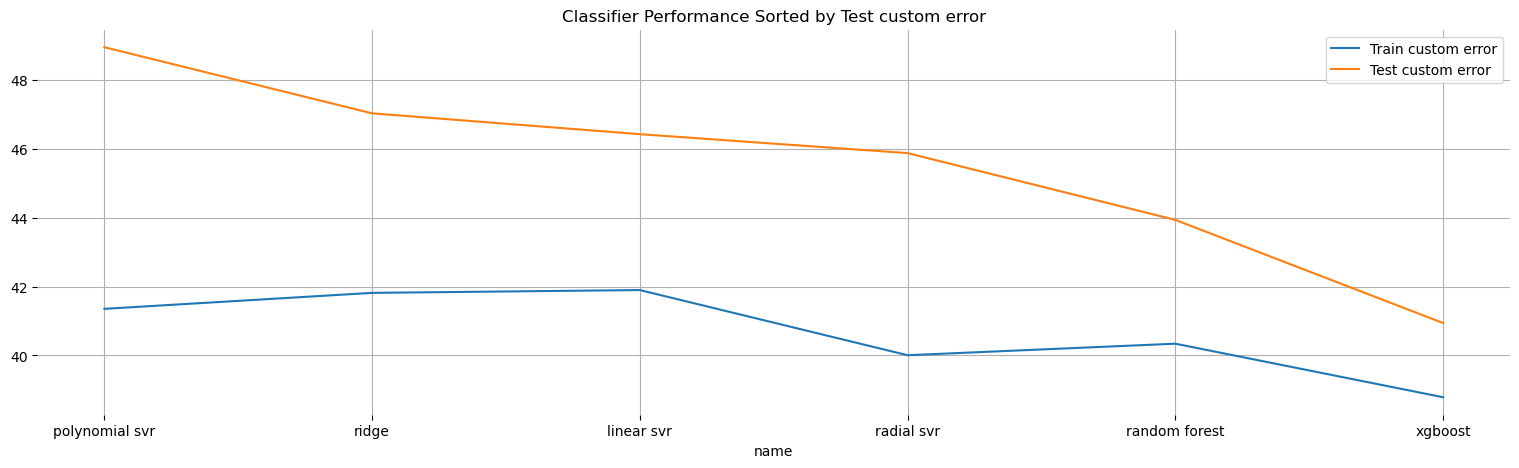

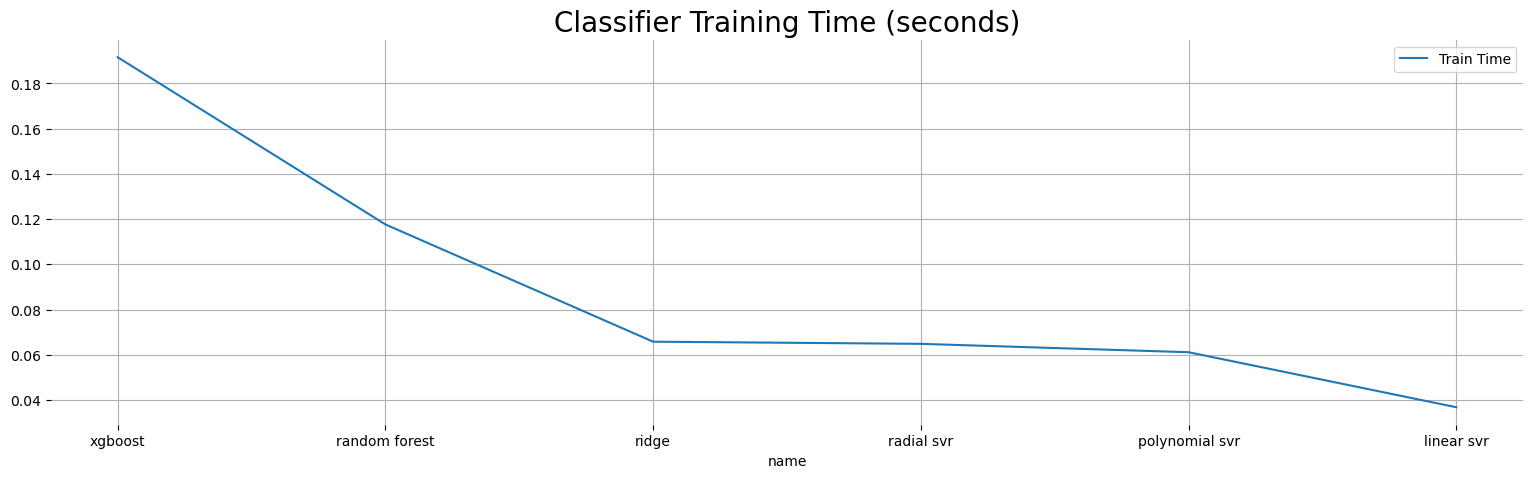

In [61]:
# Comparaison des scores et temps d'entrainement
#setup_plot()
results_df = pd.DataFrame(results)

# Custom Error
results_df.sort_values("test_custom_error", inplace=True, ascending=False) 
ax = results_df[["train_custom_error","test_custom_error", "name"]]\
        .plot(kind="line", x="name", figsize=(19,5), grid=True,
              title="Classifier Performance Sorted by Test custom error")
ax.legend(["Train custom error", "Test custom error"])
plt.box(False)

# Train time
results_df.sort_values("train_time", inplace=True, ascending=False)
ax = results_df[["train_time", "name"]].plot(kind="line", x="name", 
                                             figsize=(19,5), grid=True, 
                                title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)  

- XGBoost et Random Forest sont les modèles ayant le meilleur score de tous, mais XGBoost semble overfitter. Ils sont également ceux qui se généralisent le mieux.
- Ridge est le modèle le plus rapide pour l'entrainement tandis que XGBoost est le plus lent. Néanmoins ces temps sont très faibles. 

Conclusion : XGBoost est le modèle le plus approprié car il est suffisament rapide tout en étant le plus précis, le tout sans overfitter.

Nous allons maintenant peaufiner l'optimisation des paramètres du modèle.

In [62]:
### ROUND 1

xgbr = XGBRegressor(objective="reg:squarederror", seed=seed)

# Grille de paramètres
param_grid = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.05],
    "gamma": [0, 2, 4],
    "reg_lambda": [0],
    "subsample": [0.6, 0.7],
    "colsample_bytree": [0.7, 0.8]
             }

# critère de sélection du meilleur modèle
# R² n'a pas de sens pour les modèles non linéaires
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_xgbr = GridSearchCV(
                        estimator=xgbr, 
                        param_grid=param_grid, 
                        cv=5, 
                        scoring=score,
                        refit="custom_error",
                        return_train_score=True,
                        verbose=2,
                        n_jobs=-1,
                        error_score="raise"
                      )

# On automatise le preprocessing et l'entrainement 
pipe_xgbr = Pipeline(steps=[("preprocessing", ct_1), 
                            ("grid_xgbr", grid_xgbr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_xgbr.fit(X_train, y_train)

# Résultat de GridSearch
resultize(pipe_xgbr.named_steps["grid_xgbr"], 
          "rank_test_custom_error").head(100)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_reg_lambda,param_subsample,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.496150,0.012170,0.006030,0.003179,0.8,0,0.05,4,0,0.6,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-42.068160,2.995521,1,-33.490821,0.419179
1,0.650533,0.032974,0.003915,0.003122,0.7,0,0.05,4,0,0.6,"{'colsample_bytree': 0.7, 'gamma': 0, 'learnin...",-42.429235,2.995624,2,-33.885839,0.542276
2,0.538357,0.028584,0.009029,0.003234,0.8,0,0.05,4,0,0.7,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-42.433462,3.389133,3,-33.348420,0.362457
3,0.661784,0.055860,0.010196,0.002934,0.7,0,0.05,4,0,0.7,"{'colsample_bytree': 0.7, 'gamma': 0, 'learnin...",-42.485589,2.885431,4,-33.628662,0.407664
4,0.577219,0.027387,0.006074,0.003113,0.8,0,0.05,3,0,0.6,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-43.341387,2.800880,5,-37.732248,0.387472
5,0.454300,0.071241,0.008629,0.003092,0.8,0,0.05,3,0,0.7,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-43.532293,2.391431,6,-37.945108,0.620856
6,0.448451,0.030348,0.010366,0.002454,0.7,0,0.05,3,0,0.6,"{'colsample_bytree': 0.7, 'gamma': 0, 'learnin...",-43.716934,2.846131,7,-38.210280,0.490818
7,0.550837,0.025429,0.009240,0.003547,0.7,0,0.05,3,0,0.7,"{'colsample_bytree': 0.7, 'gamma': 0, 'learnin...",-43.745303,2.841682,8,-38.118251,0.543288
8,0.405059,0.017059,0.007548,0.004679,0.8,0,0.05,2,0,0.6,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-45.289026,2.330302,9,-42.276140,0.639437
9,0.436017,0.015611,0.007416,0.003860,0.8,0,0.05,2,0,0.7,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-45.569598,2.155871,10,-42.367285,0.593237


Les meilleurs paramètres du modèle sont ceux à l'indice 7, car c'est avec ces dernniers qu'on a le meilleur conpromis entre erreur faible et excellente généralisation.

In [63]:
best_params = {
                "max_depth": 2,
                "learning_rate": 0.05,
                "gamma": 0,
                "reg_lambda": 0,
                "subsample": 0.6,
                "colsample_bytree": 0.8
              }

Nous allons re-entrainer le modèle avec ces derniers, sur l'ensemble du training set

In [64]:
# On entraine le modèle avec ces paramètres
xgbr = XGBRegressor(objective="reg:squarederror", seed=seed, **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_xgbr = Pipeline(steps=[("preprocessing", ct_1), 
                            ("xgbr", xgbr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_xgbr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_xgbr.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"test custom error : {score_:.3f}")
print(f"train custom error : \
    {custom_metric(y_train, pipe_xgbr.predict(X_train)):.3f}")

Temps écoulé pour entrainer le modèle : 0.158s
test custom error : 42.862
train custom error :     42.864


# 5 - Analyse du modèle

## 5.1 - Erreurs du modèle

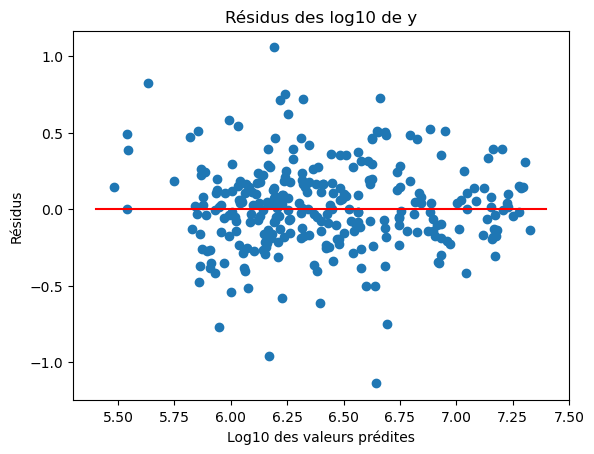

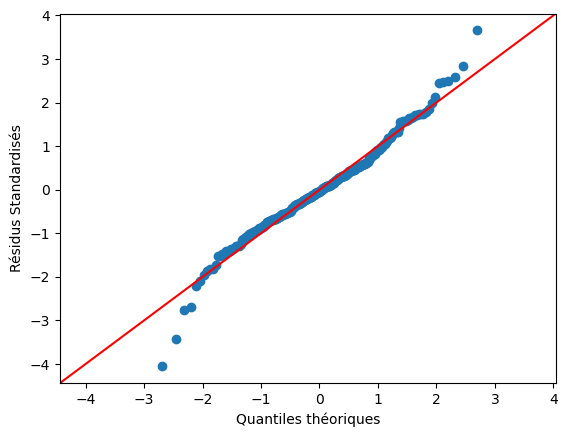

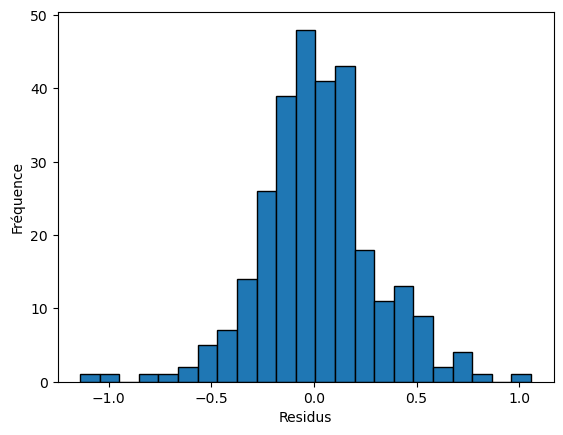

In [65]:
# Graphe des résidus
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.plot([5.4, 7.4], [0, 0], color="r")
plt.xlabel("Log10 des valeurs prédites")
plt.ylabel("Résidus")
plt.title("Résidus des log10 de y")
plt.show()

# qqplot des résidus
sm.qqplot((residuals-residuals.mean())/residuals.std(), line='45')
plt.xlabel("Quantiles théoriques")
plt.ylabel("Résidus Standardisés")
plt.show()

# Histogramme des résidus
plt.hist(residuals, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residus")
plt.ylabel("Fréquence")
plt.show()

- Le 1er graphe montre que les résidus sont aléatoires, dispersés et centrés autour de 0. Aucune forme ou tendance n'est lisible dessus, ce qui signifie que les résidus ne représentent donc que le "bruit" du modèle. Pour rappel, c'est ce qui est souhaité. 
- Les 2 autres graphes montrent que les résidus suivent bien une loi normale centrée. 

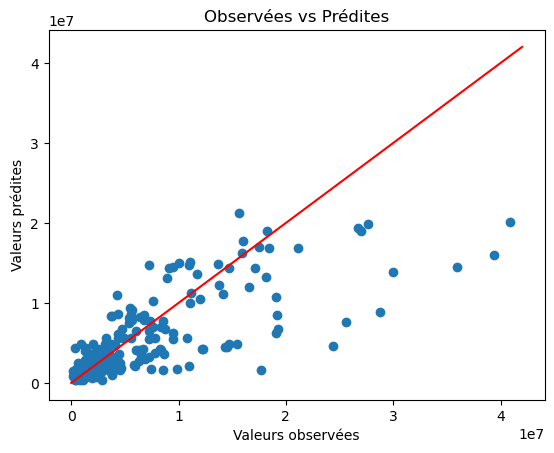

In [66]:
plt.scatter(10**y_test, 10**y_pred)
plt.plot([0, 4.2e7], [0, 4.2e7], color="r")
plt.xlabel("Valeurs observées")
plt.ylabel("Valeurs prédites")
plt.title("Observées vs Prédites")
plt.show()

Le modèle est assez correct pour des propriétés dont la consommation énergétique est inférieure à 2e7. Au delà de cette valeur, le modèle a tendance à largement sous-estimer la consommation énergétique.

## 5.2 - Feature importance globale

In [67]:
train_result = permutation_importance(
    pipe_xgbr, X_train, y_train, n_repeats=10, scoring=custom_error,
    random_state=seed, n_jobs=-1
)
test_results = permutation_importance(
    pipe_xgbr, X_test, y_test, n_repeats=10, scoring=custom_error,
    random_state=seed, n_jobs=-1
)
sorted_importances_idx = train_result.importances_mean.argsort()

In [68]:
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)

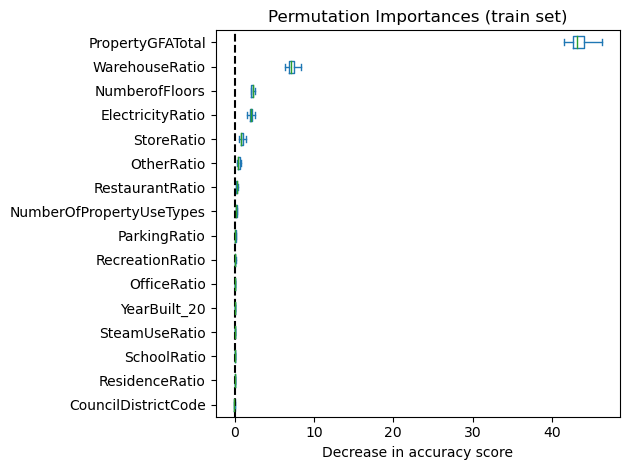

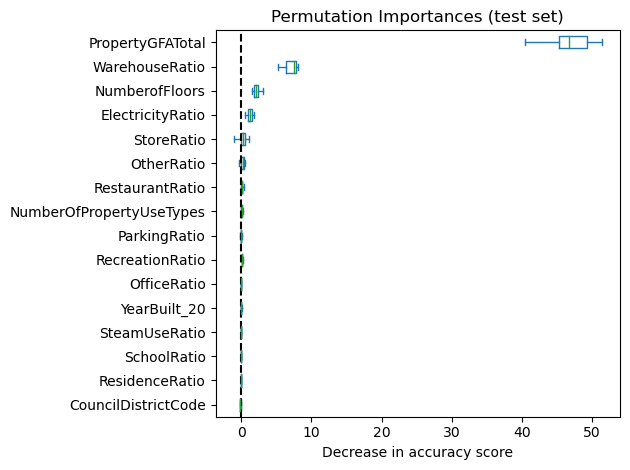

In [69]:
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout() 

- `PropertyGFATotal` est en moyenne la feature la plus importante pour prédire la consommation énergétique totale. Modifier ou supprimer ses valeurs entrainent une chute de près de 5 points sur le score du modèle. Suivent ensuite `WarehouseRatio` et `ElectricityRatio` et `NumberofFloors`.

- Pour les autres features, l'impact sur la prédiction finale est en moyenne quasiment nul voir nul.

- Le modèle ne semble pas overfitter, l'importance relative des features restant quasiment inchangée entre le test set et le train set.

## 5.3 - Feature d'importance locale

Etant donné qu'on prédit log10(y), la feature d'importance locale ne peut que nous renseigner sur comment on obtient...log10(y). La consommation prédite vaut 10^y.

In [70]:
X_shap = X.copy()
y_shap = y.copy()

# OneHotEncoding de X_shap
X_shap = pd.get_dummies(X_shap, columns=categorical_features, drop_first=True)

# On reffectue le split de X_shap,
X_train_shap, X_test_shap, y_train_shap, y_test_shap = \
    train_test_split(X_shap, y_shap, test_size=0.2, random_state=seed, 
                     stratify=data["SiteEUI_bins"])

# Application de la transformation logarithmique de PropertyGFATotal
X_train_shap["PropertyGFATotal"] = \
    X_train_shap["PropertyGFATotal"].map(log10_transform)
X_test_shap["PropertyGFATotal"] = \
    X_test_shap["PropertyGFATotal"].map(log10_transform)

# Application du robust scaler
X_train_shap["NumberofFloors"] = \
    r_scaler.fit_transform(X_train_shap[["NumberofFloors"]])
X_test_shap["NumberofFloors"] = \
    r_scaler.transform(X_test_shap[["NumberofFloors"]])

# Entrainement du modèle
xgbr_shap = XGBRegressor(objective="reg:squarederror", seed=seed, 
                         **best_params)
xgbr_shap.fit(X_train_shap, y_train_shap)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Expected/Base Value :  6.4005895

Prediction From Model :  [6.143471]

Prediction From Adding SHAP Values to Base Value :  [6.1434717]


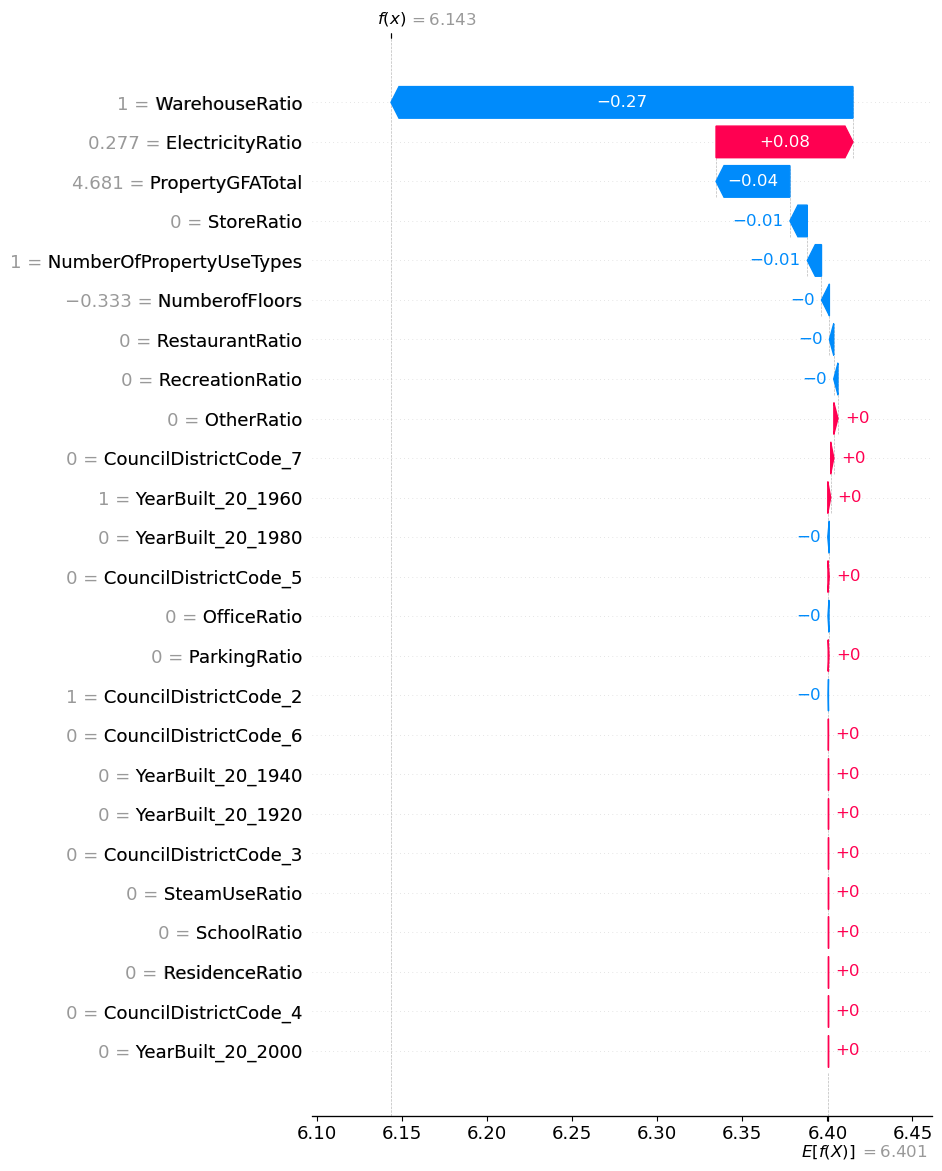

In [71]:
tree_explainer = shap.TreeExplainer(xgbr_shap)

# Sélectionnons 1 indice au hasard
random.seed(seed+10000)
idx = random.sample(X_test_shap.index.tolist(), 1)

# Shap values de l'individu sélectionné
shap_vals = tree_explainer.shap_values(X_test_shap.loc[idx, :])

print("Expected/Base Value : ", tree_explainer.expected_value)
print("\nPrediction From Model : ", 
      xgbr_shap.predict(X_test_shap.loc[idx, :]))
print("\nPrediction From Adding SHAP Values to Base Value : ", 
      tree_explainer.expected_value + shap_vals.sum(1))

shap_values = tree_explainer(X_test_shap.loc[idx, :])
shap_values.feature_names = X_test_shap.columns.tolist()
shap.waterfall_plot(shap_values[0], max_display=X_test_shap.shape[1])

Pour cette  propriété, `WarehouseRatio`, `PropertyGFATotal` et `ElectricityRatio` sont les features qui contribuent le plus à la prédiction finale. Le reste des features a une contribution négligeable, voir nulle. 

Regardons maintenant les interactions entre les features.

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


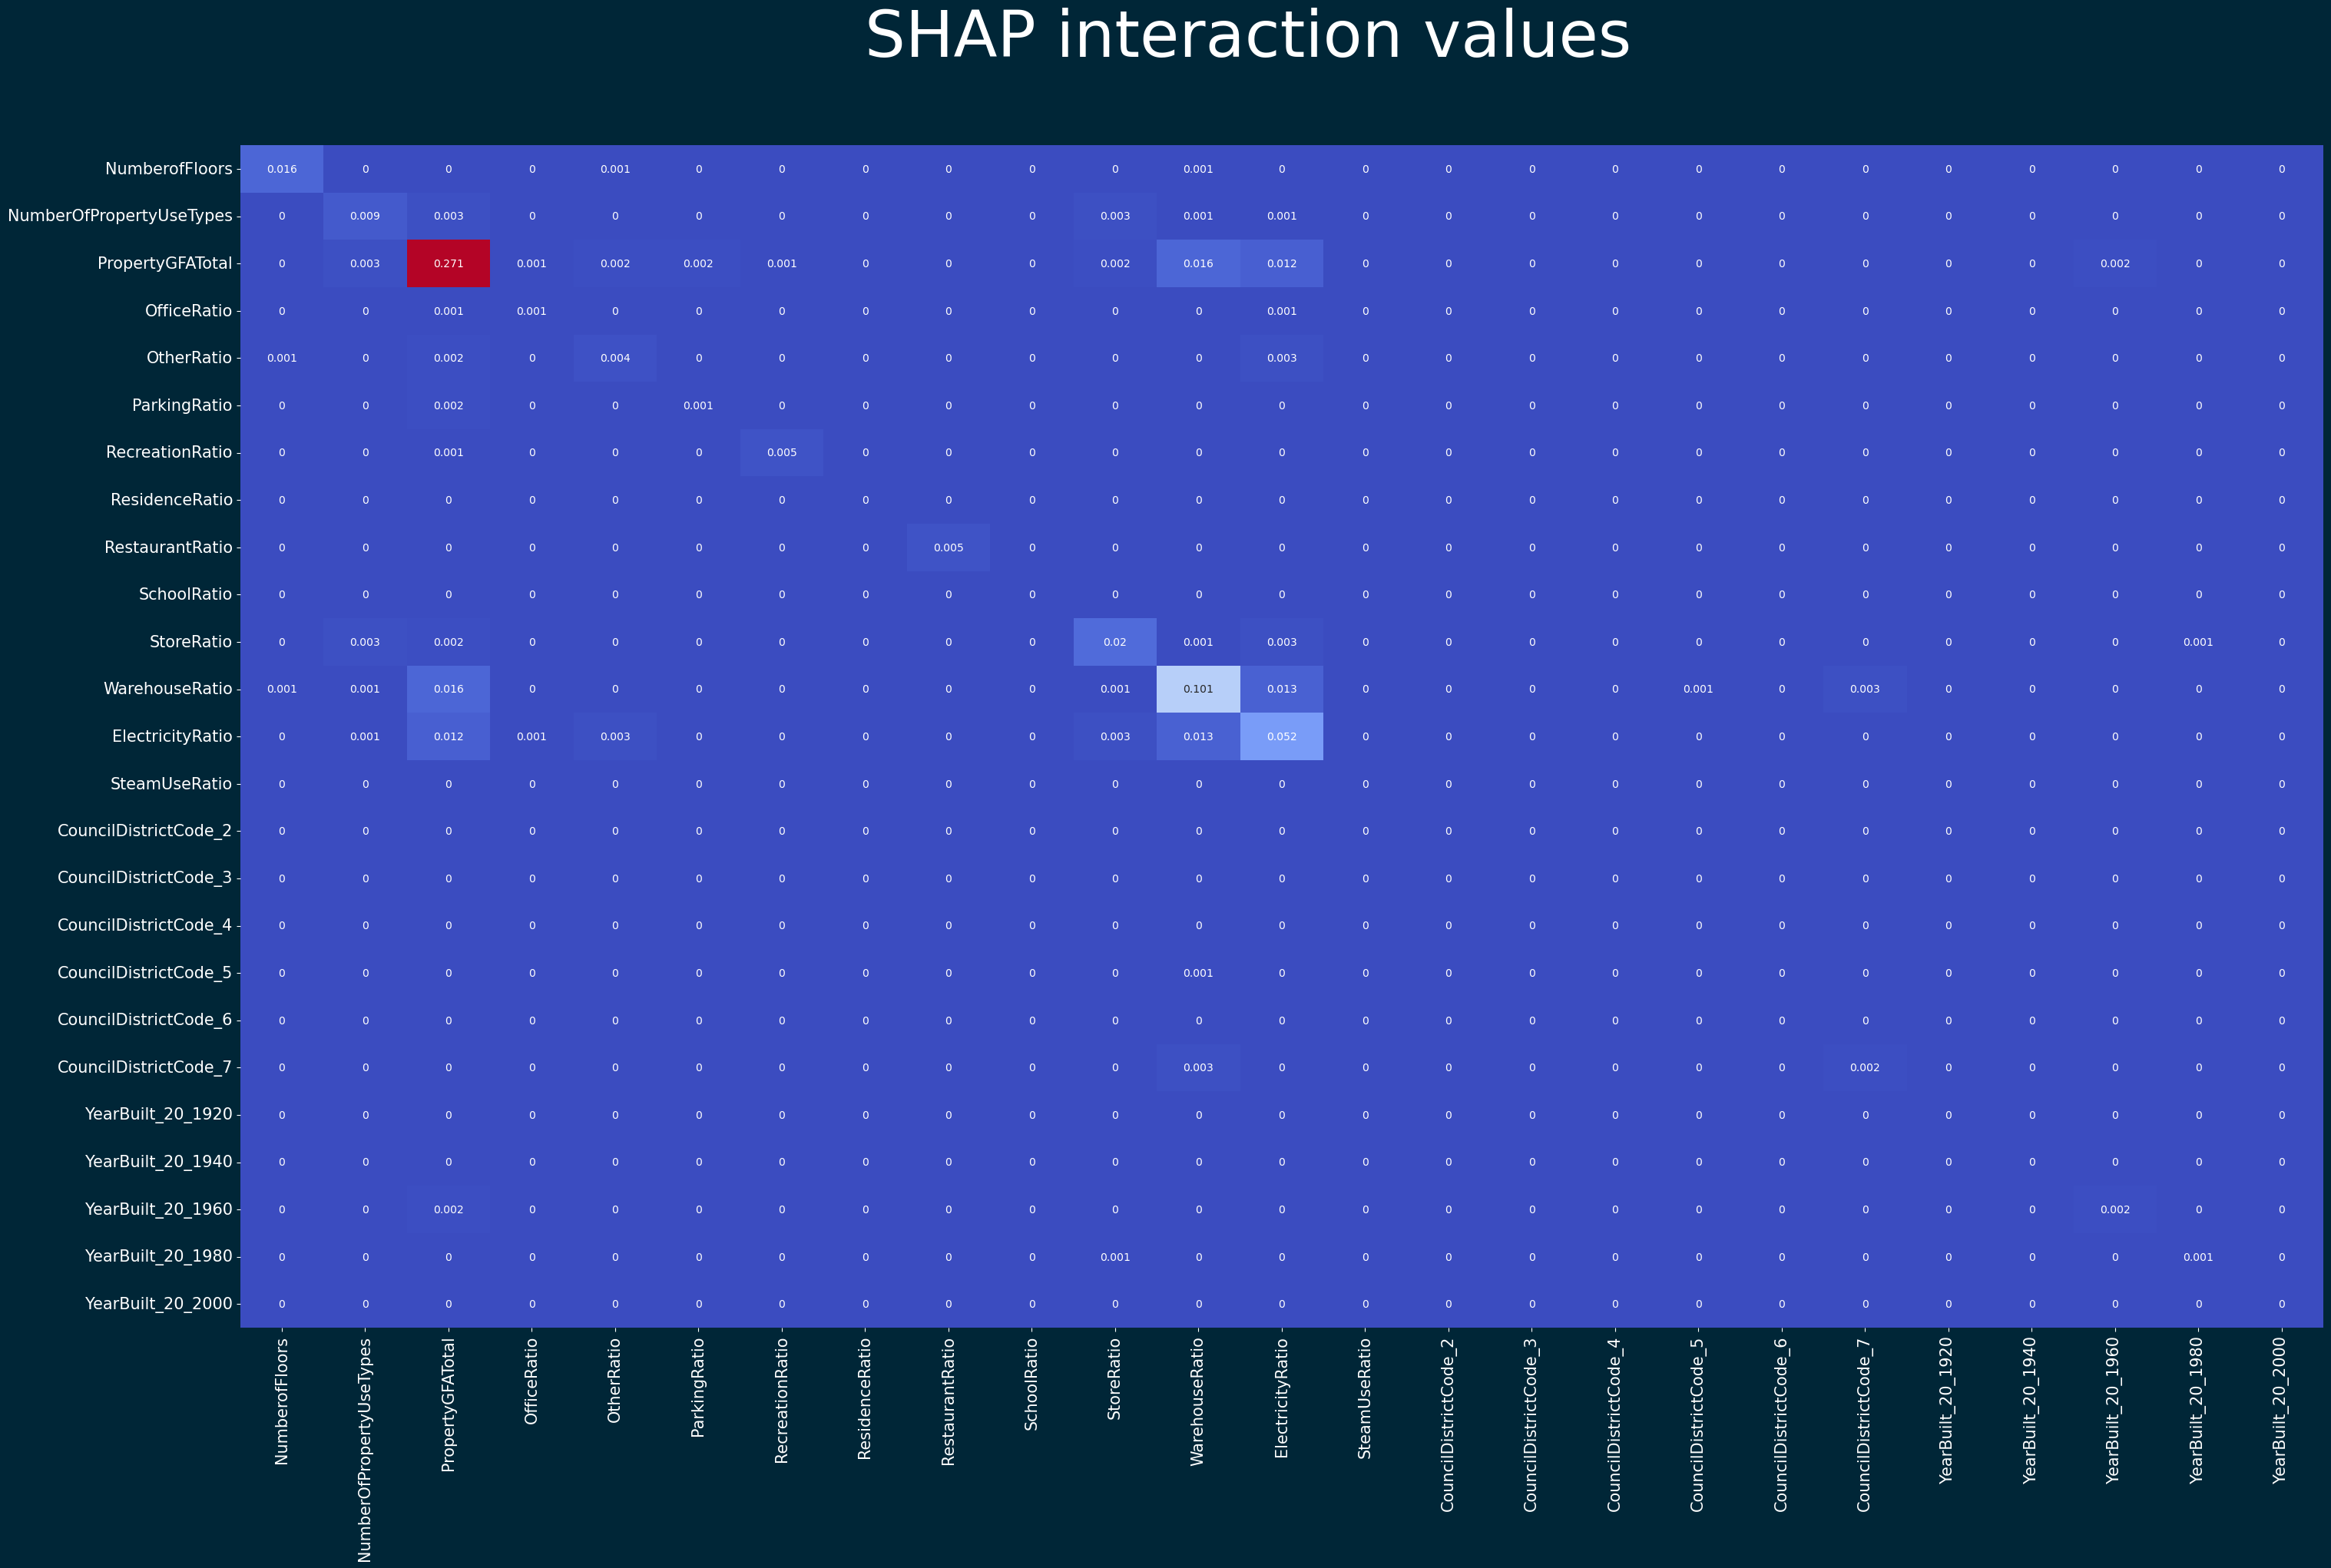

In [72]:
# SHAP interaction contributions:
shap_interaction = tree_explainer.shap_interaction_values(X_train_shap)

# On calcule les moyennes absolues des features
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap, index=X_shap.columns, columns=X_shap.columns)

# On multiplie les termes de diagonale par 2
df.where(df.values == np.diagonal(df), df.values*2, inplace=True)

# Graphe 
fig = plt.figure(figsize=(35, 20), facecolor='#002637', edgecolor='r')
ax = fig.add_subplot()
sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=False, ax=ax, )
ax.tick_params(axis='x', colors='w', labelsize=15, rotation=90)
ax.tick_params(axis='y', colors='w', labelsize=15)

plt.suptitle("SHAP interaction values", color="white", fontsize=60, y=0.97)
plt.yticks(rotation=0) 
plt.show()

Les termes de la diagonale permettent de savoir les features dont l'impact est significatif pour le modèle. Dans notre cas, on obtient à peu près le même résultat que ce qui a été observé en partie 5.2 avec la Permutation Feature importance. 

Les termes hors diagonale correspondent aux interactions entre les features. Les valeurs sont quasiment nulles voir nulles. L'interaction la plus forte est entre les features `WarehouseRatio` et `PropertyGFATotal` et vaut 0,027.

# 6 - Intérêt de l'ENERGY STAR SCORE

Dans cette partie, nous allons ajouter la feature `ENERGYSTARScore` et voir si oui ou non elle améliore la précision du modèle. Pour rappel, sans prise en compte de cette feature, les résultats obtenus étaient les suivants : 

- Temps écoulé pour entrainer le modèle : 0.158s
- test custom error : 42.862
- train custom error :     42.864

Nota : Il n'est pas nécessaire d'imputer (ou supprimer) les valeurs manquantes de cette feature, car l'imputation des valeurs manquantes est intégrée dans l'algorithme de prédiction de la librairie XGBoost.

In [73]:
# On re-sélectionne les features catégorielles
X_ess = data.copy().loc[:, [*categorical_features, *numerical_features, 
                        *ratio_features, "ENERGYSTARScore"]]

# On re-effectue le split de X_ess
X_ess_train, X_ess_test = \
    train_test_split(X_ess, test_size=0.2, random_state=seed, 
                     stratify=data["SiteEUI_bins"])

# On va également standardiser la feature ENERGYSTARScore
ct_3 = ColumnTransformer(
     transformers=[("log_transformer", log_transformer, ["PropertyGFATotal"]), 
                   ("one_hot_encoder", oh_enc, categorical_features), 
                   ("scaler", r_scaler, ["NumberofFloors", "ENERGYSTARScore"])
                  ], 
    remainder="passthrough",
    n_jobs=-1)

# On entraine le modèle avec ces paramètres
xgbr = XGBRegressor(objective="reg:squarederror", seed=seed, **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_xgbr = Pipeline(steps=[("preprocessing", ct_3), 
                            ("xgbr", xgbr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_xgbr.fit(X_ess_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_xgbr.predict(X_ess_test)
score_ = custom_metric(y_test, y_pred)
print(f"test custom error : {score_:.3f}")
print(f"train custom error : \
    {custom_metric(y_train, pipe_xgbr.predict(X_ess_train)):.3f}")

Temps écoulé pour entrainer le modèle : 0.126s
test custom error : 39.947
train custom error :     39.679


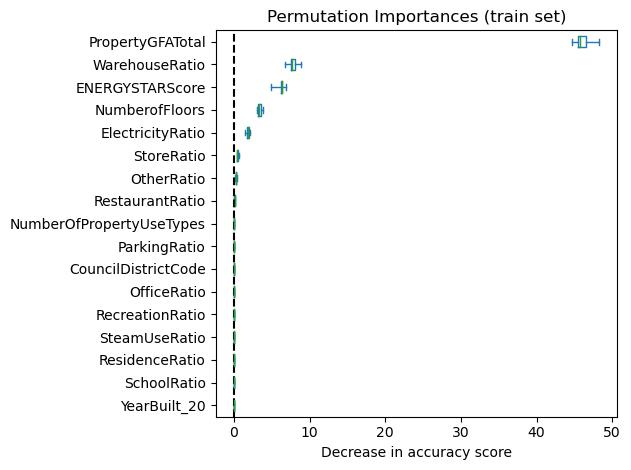

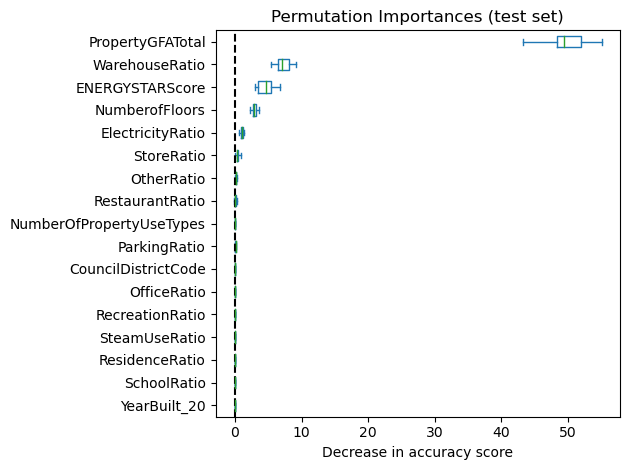

In [74]:
train_result = permutation_importance(
    pipe_xgbr, X_ess_train, y_train, n_repeats=10, scoring=custom_error,
    random_state=seed, n_jobs=-1
)
test_results = permutation_importance(
    pipe_xgbr, X_ess_test, y_test, n_repeats=10, scoring=custom_error,
    random_state=seed, n_jobs=-1
)
sorted_importances_idx = train_result.importances_mean.argsort()

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X_ess_train.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X_ess_train.columns[sorted_importances_idx],
)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout() 

Il apparait que la prise en compte de `ENERGYSTARScore` améliore légèrement la précision de notre modèle. l'erreur diminue de 3%.  

En particulier, si on regarde l'influence moyenne relative des features sur le score modèle, on se rend compte que `ENERGYSTARScore` est après `PropertyGFATotal` et `WarehouseRatio` la feature la plus importante pour la prédiction.